In [206]:
import dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)
import matplotlib.pyplot as plt
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage import data
import scipy.ndimage as ndi
import cv2
import numpy as np



# Change this to wherever you are storing your data:
# IF YOU ARE FOLLOWING ON KAGGLE, YOU CAN ONLY PLAY WITH THE SAMPLE DATA, WHICH IS MUCH SMALLER

data_dir = 'C:/Users/annam/Desktop/ML/ML - Project/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('C:/Users/annam/Desktop/ML/ML - Project/stage1_labels.csv', index_col=0)

In [113]:
labels_df.head(5)

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


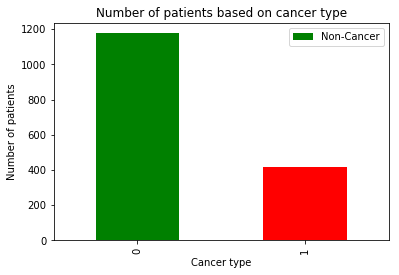

In [114]:
labels_df['cancer'].value_counts().plot(kind='bar', color = ['green', 'red'], label='Non-Cancer')
plt.title("Number of patients based on cancer type")
plt.xlabel("Cancer type")
plt.ylabel("Number of patients")
plt.legend(loc='best')
plt.show()

In [127]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print('Pixel array of a slice:',slices[0].pixel_array.shape)

Pixel array of a slice: (512, 512)


Cancer: 1


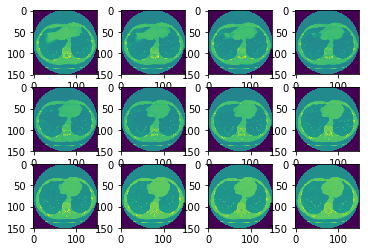

Cancer: 0


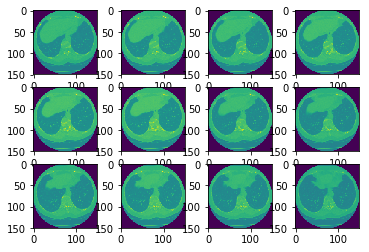

In [202]:
IMG_PX_SIZE = 150
new_image = []

for patient in patients[:2]:
    label = labels_df.get_value(patient, 'cancer')
    print('Cancer:',label)
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    fig = plt.figure()
    for num,each_slice in enumerate(slices[60:72]):
        y = fig.add_subplot(3,4,num+1)
        new_image = np.array(cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)))
        y.imshow(new_image)
    plt.show()

## Extracting Features 1 (Pixel values)

Patient ID: 0015ceb851d7251b8f399e39779d1e7d
Cancer: 1


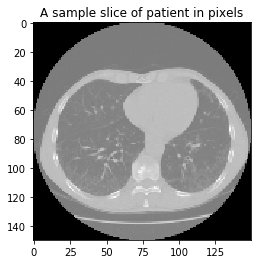

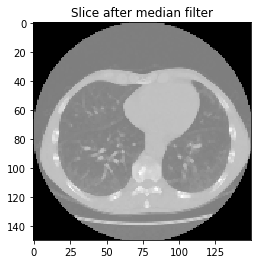

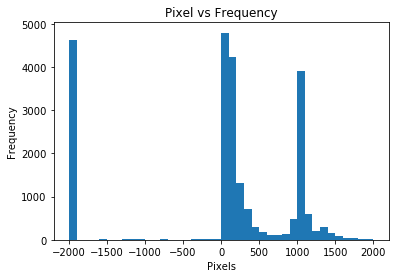

Patient ID: 0030a160d58723ff36d73f41b170ec21
Cancer: 0


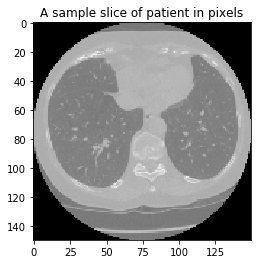

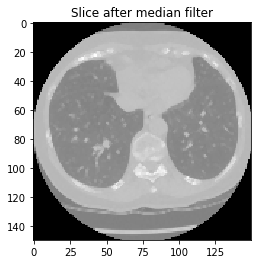

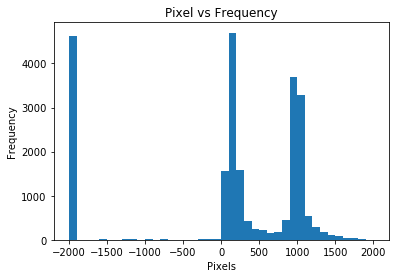

In [141]:
IMG_PX_SIZE = 150
new_image = []

for patient in patients[:2]:
    label = labels_df.get_value(patient, 'cancer')
    print('Patient ID:', patient)
    print('Cancer:',label)
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness    
    
    for num,each_slice in enumerate(slices[:80]):
        new_image = np.array(cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)))
        
    plt.imshow(new_image, cmap=plt.cm.gray, interpolation='nearest')
    plt.title("A sample slice of patient in pixels")
    plt.show()
    
    img_med = ndi.median_filter(new_image, size=2)
    plt.imshow(img_med, cmap=plt.cm.gray, interpolation='nearest')
    plt.title("Slice after median filter")
    plt.show()
    
    plt.hist(img_med.flat, bins=40, range=(-2000,2000))
    plt.title("Pixel vs Frequency")
    plt.xlabel("Pixels")
    plt.ylabel("Frequency")
    plt.show()

In [142]:
#Read that pixel range for leisons is in the range of 44 to 132
min_lesion = 44
max_lesion = 132
lungs = img_med < min_lesion
lesions = (img_med >= min_lesion) & (img_med <= max_lesion)
others = img_med > max_lesion

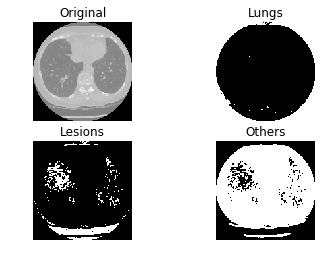

In [143]:
def plot_images(cmap = plt.cm.gray):
    for n, (name, image) in \
        enumerate([('Original', img_med), ('Lungs', lungs), 
                   ('Lesions',lesions), ('Others', others)]):
            plt.subplot(2,2,n+1)
            plt.imshow(image, cmap=cmap)
            plt.title(name)
            plt.axis('off')
plot_images();
plt.show()

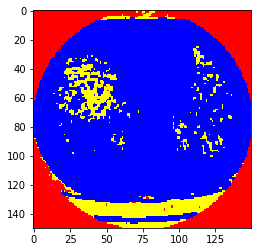

In [144]:
def plot_color_overlay():
    all_layers = np.zeros((new_image.shape[0], new_image.shape[1], 3))
    #assert(lesions.dtype == np.bool)
    all_layers[lungs] = (1,0,0)
    all_layers[lesions] = (1,1,0)
    all_layers[others] = (0,0,1)
    plt.imshow(all_layers)

plot_color_overlay()
plt.show()

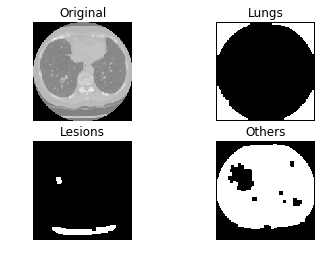

In [145]:
#Morphological operations
for img in (lungs, lesions, others):
    img[:] = ndi.binary_opening(img, np.ones((5,5)))
    img[:] = ndi.binary_closing(img, np.ones((5,5)))
plot_images()
plt.show()

4 region found in Lungs
Mean object area is 977.0
2 region found in Lesions
Mean object area is 71.0
1 region found in Others


C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean object area is nan


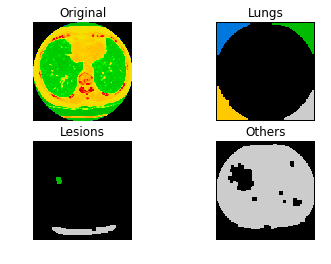

In [146]:
lungs = lungs.astype(int)
lesions = lesions.astype(int)
others = others.astype(int)

for name, img in [('Lungs', lungs),('Lesions',lesions),('Others', others)]:
    lables, count = ndi.label(img)
    print (str(count) + ' ' + 'region found in' + ' ' + name)
    img[:] = lables
    obj_areas = [np.sum(lables == i) for \
                i in range(1, lables.max())]
    print ('Mean object area is' + ' ' + str(np.mean(obj_areas)))

plot_images(cmap = plt.cm.spectral)
plt.show()

In [147]:
data_dir = 'C:/Users/annam/Desktop/ML/ML - Project/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('C:/Users/annam/Desktop/ML/ML - Project/stage1_labels.csv', index_col=0)

IMG_PX_SIZE = 150
min_lesion_HU = 44
max_lesion_HU = 132
patient_df = pd.DataFrame(columns=['Patient','Lu_count','Lu_area','Le_count','Le_area','Ot_count','Ot_area','Cancer'])
count = 0

for patient in patients[:2]: #Change 2 to len(patients) to get values for all patients
    print(patient)
    lungs_df = pd.DataFrame(columns=['Count','Mean area'])
    lesions_df = pd.DataFrame(columns=['Count','Mean area'])
    others_df = pd.DataFrame(columns=['Count','Mean area'])        
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

    for num,each_slice in enumerate(slices[:len(slices)]):
        new_image = np.array(cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)))
        img_med = ndi.median_filter(new_image, size=2)
        lungs = img_med < min_lesion_HU
        lesions = (img_med >= min_lesion_HU) & (img_med <= max_lesion_HU)
        others = img_med > max_lesion_HU
        for img in (lungs, lesions, others):
            img[:] = ndi.binary_opening(img, np.ones((5,5)))
            img[:] = ndi.binary_closing(img, np.ones((5,5)))

        lungs = lungs.astype(int)
        lesions = lesions.astype(int)
        others = others.astype(int)
        for name, img in [('Lungs', lungs),('Lesions',lesions),('Others', others)]:
            lables, count = ndi.label(img)
            obj_areas = [np.sum(lables == i) for i in range(1, lables.max())]
            img[:] = lables
            if (name == 'Lungs'):
                lungs_df.loc[len(lungs_df)] = [count,np.mean(obj_areas)]
            elif (name == 'Lesions'):
                lesions_df.loc[len(lesions_df)] = [count,np.mean(obj_areas)]
            else:
                others_df.loc[len(others_df)] = [count,np.mean(obj_areas)]

    patient_df.loc[len(patient_df)] = [patient, lungs_df['Count'].mean(), lungs_df['Mean area'].mean(), lesions_df['Count'].mean(), lesions_df['Mean area'].mean(),others_df['Count'].mean(), others_df['Mean area'].mean(), label]
    #print(patient_df)

0015ceb851d7251b8f399e39779d1e7d


C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                            Patient  Lu_count      Lu_area  Le_count  \
0  0015ceb851d7251b8f399e39779d1e7d  3.235897  3460.122308  4.097436   

      Le_area  Ot_count  Ot_area  Cancer  
0  157.226361  1.246154   7495.3     1.0  
0030a160d58723ff36d73f41b170ec21
                            Patient  Lu_count      Lu_area  Le_count  \
0  0015ceb851d7251b8f399e39779d1e7d  3.235897  3460.122308  4.097436   
1  0030a160d58723ff36d73f41b170ec21  3.607547  1510.217296  4.747170   

      Le_area  Ot_count      Ot_area  Cancer  
0  157.226361  1.246154  7495.300000     1.0  
1   72.902637  1.460377  8804.406746     0.0  


In [148]:
#patient_df.to_csv('features_pixel_lungs.csv')
patient_df.head()

,Patient,Lu_count,Lu_area,Le_count,Le_area,Ot_count,Ot_area,Cancer
0,0015ceb851d7251b8f399e39779d1e7d,3.235897,3460.122308,4.097436,157.226361,1.246154,7495.300000,1.0
1,0030a160d58723ff36d73f41b170ec21,3.607547,1510.217296,4.747170,72.902637,1.460377,8804.406746,0.0


## Extracting features 2 (Hounsfield unit (HU))

In [207]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)

Patient ID: 0015ceb851d7251b8f399e39779d1e7d
Cancer: 1


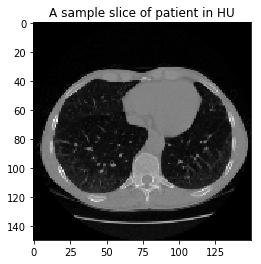

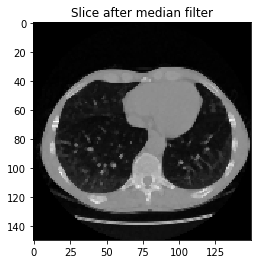

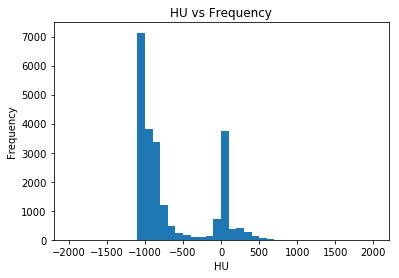

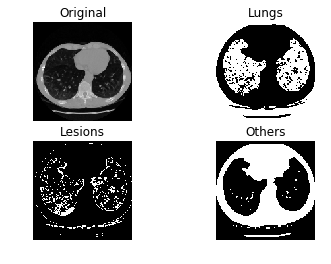

Patient ID: 0030a160d58723ff36d73f41b170ec21
Cancer: 0


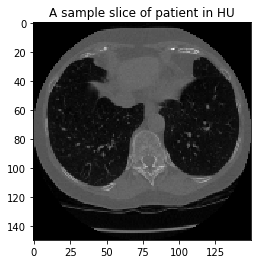

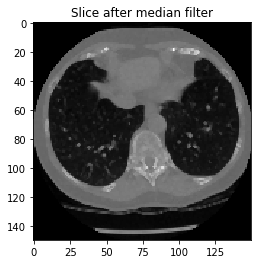

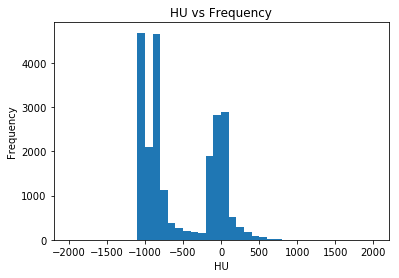

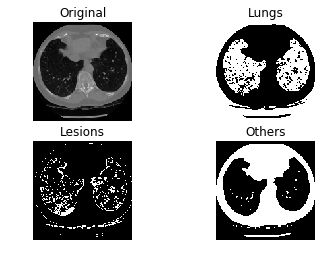

In [212]:
IMG_PX_SIZE = 150
new_image = []

min_lesion_HU = -800
max_lesion_HU = -400
lungs = img_med < min_lesion_HU
lesions = (img_med >= min_lesion_HU) & (img_med <= max_lesion_HU)
others = img_med > max_lesion_HU

for patient in patients[:2]:
    label = labels_df.get_value(patient, 'cancer')
    print('Patient ID:', patient)
    print('Cancer:',label)
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    slices = get_pixels_hu(slices)
    
    for num,each_slice in enumerate(slices[:72]):
        new_image = np.array(cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE)))
        
    plt.imshow(new_image, cmap=plt.cm.gray, interpolation='nearest')
    plt.title("A sample slice of patient in HU")
    plt.show()
    
    img_med = ndi.median_filter(new_image, size=2)
    plt.imshow(img_med, cmap=plt.cm.gray, interpolation='nearest')
    plt.title("Slice after median filter")
    plt.show()
    
    plt.hist(img_med.flat, bins=40, range=(-2000,2000))
    plt.title("HU vs Frequency")
    plt.xlabel("HU")
    plt.ylabel("Frequency")
    plt.show()
    
    def plot_images(cmap = plt.cm.gray):
        for n, (name, image) in \
            enumerate([('Original', img_med), ('Lungs', lungs), 
                       ('Lesions',lesions), ('Others', others)]):
                plt.subplot(2,2,n+1)
                plt.imshow(image, cmap=cmap)
                plt.title(name)
                plt.axis('off')
    plot_images()
    plt.show()

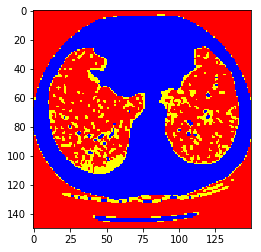

In [209]:
def plot_color_overlay():
    all_layers = np.zeros((new_image.shape[0], new_image.shape[1], 3))
    #assert(lesions.dtype == np.bool)
    all_layers[lungs] = (1,0,0)
    all_layers[lesions] = (1,1,0)
    all_layers[others] = (0,0,1)
    plt.imshow(all_layers)
plot_color_overlay()
plt.show()

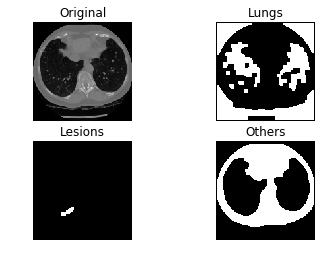

In [210]:
#Morphological operations
for img in (lungs, lesions, others):
    img[:] = ndi.binary_opening(img, np.ones((5,5)))
    img[:] = ndi.binary_closing(img, np.ones((5,5)))
plot_images()
plt.show()

9 region found in Lungs
Mean object area is 1058.875
1 region found in Lesions
Mean object area is nan
1 region found in Others
Mean object area is nan


C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


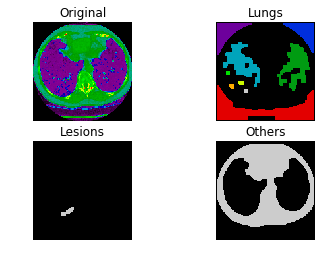

In [211]:
lungs = lungs.astype(int)
lesions = lesions.astype(int)
others = others.astype(int)

for name, img in [('Lungs', lungs),('Lesions',lesions),('Others', others)]:
    lables, count = ndi.label(img)
    print (str(count) + ' ' + 'region found in' + ' ' + name)
    img[:] = lables
    obj_areas = [np.sum(lables == i) for \
                i in range(1, lables.max())]
    print ('Mean object area is' + ' ' + str(np.mean(obj_areas)))

plot_images(cmap = plt.cm.spectral)
plt.show()

In [199]:
data_dir = 'C:/Users/annam/Desktop/ML/ML - Project/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('C:/Users/annam/Desktop/ML/ML - Project/stage1_labels.csv', index_col=0)

IMG_PX_SIZE = 150
min_lesion_HU = -800
max_lesion_HU = -400
patient_df = pd.DataFrame(columns=['Patient','Lu_count','Lu_area','Le_count','Le_area','Ot_count','Ot_area','Cancer'])
count = 0
for patient in patients[:2]: #Change 2 to len(patients) to get values for all patients
    print(patient)
    lungs_df = pd.DataFrame(columns=['Count','Mean area'])
    lesions_df = pd.DataFrame(columns=['Count','Mean area'])
    others_df = pd.DataFrame(columns=['Count','Mean area'])        
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    slices = get_pixels_hu(slices)

    for num,each_slice in enumerate(slices[:len(slices)]):
        new_image = np.array(cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE)))
    
        img_med = ndi.median_filter(new_image, size=2)
        lungs = img_med < min_lesion_HU
        lesions = (img_med >= min_lesion_HU) & (img_med <= max_lesion_HU)
        others = img_med > max_lesion_HU
        for img in (lungs, lesions, others):
            img[:] = ndi.binary_opening(img, np.ones((5,5)))
            img[:] = ndi.binary_closing(img, np.ones((5,5)))

        lungs = lungs.astype(int)
        lesions = lesions.astype(int)
        others = others.astype(int)
        for name, img in [('Lungs', lungs),('Lesions',lesions),('Others', others)]:
            lables, count = ndi.label(img)
            obj_areas = [np.sum(lables == i) for i in range(1, lables.max())]
            img[:] = lables
            if (name == 'Lungs'):
                lungs_df.loc[len(lungs_df)] = [count,np.mean(obj_areas)]
            elif (name == 'Lesions'):
                lesions_df.loc[len(lesions_df)] = [count,np.mean(obj_areas)]
            else:
                others_df.loc[len(others_df)] = [count,np.mean(obj_areas)]

    patient_df.loc[len(patient_df)] = [patient, lungs_df['Count'].mean(), lungs_df['Mean area'].mean(), lesions_df['Count'].mean(), lesions_df['Mean area'].mean(),others_df['Count'].mean(), others_df['Mean area'].mean(), label]

0015ceb851d7251b8f399e39779d1e7d


C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\annam\Miniconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0030a160d58723ff36d73f41b170ec21


In [200]:
#patient_df.to_csv('features_HU_lungs.csv')
patient_df.head()

,Patient,Lu_count,Lu_area,Le_count,Le_area,Ot_count,Ot_area,Cancer
0,0015ceb851d7251b8f399e39779d1e7d,3.758974,4568.797607,1.148718,133.735641,1.128205,6345.895833,1.0
1,0030a160d58723ff36d73f41b170ec21,5.003774,1815.635322,0.381132,48.900000,1.060377,7942.866667,0.0
